# Партнерская задача: тематическая классификация текстов

In [92]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
import inflect
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from scipy.sparse import hstack
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.sparse import hstack
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score
from transformers import EarlyStoppingCallback
from pathlib import Path
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avmar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\avmar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\avmar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [162]:
import sys
print(sys.executable)

D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Scripts\python.exe


## 1. Исследование датасета и предобработка данных

даны 6 датасетов (каждый датасет - отдельный класс) + описание

разделение "текст поста", video2text [OCR], speech2text [ASR]

In [163]:
df1 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/1.csv')
df2 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/2.csv')
df3 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/3.csv')
df4 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/4.csv')
df5 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/5.csv')
df6 = pd.read_csv('https://github.com/martetten/Dataton_2/raw/main/data/raw/6.csv')

In [164]:
print(df1.info())
print(df2.info())
print(df3.info())
print(df4.info())
print(df5.info())
print(df6.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_text     1000 non-null   object
 1   image2text   568 non-null    object
 2   speech2text  338 non-null    object
dtypes: object(3)
memory usage: 23.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_text     1000 non-null   object
 1   image2text   418 non-null    object
 2   speech2text  191 non-null    object
dtypes: object(3)
memory usage: 23.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   doc_text     1000 non-null   object
 1   image2text   521 non-null    object
 2   speech2text  2

In [97]:
# df1 = df1.drop(columns='class')

In [165]:
df1['class'] = 1
df2['class'] = 2
df3['class'] = 3
df4['class'] = 4
df5['class'] = 5
df6['class'] = 6

Объедним данные в общий general датафрейм

In [166]:
df_gen = pd.concat([df1, df2, df3, df4, df5, df6]).reset_index()

In [167]:
df_gen.tail()

,index,doc_text,image2text,speech2text,class
5995,995,"Отказали ноги, стандартная ситуация! #щербако...",NaN,"Ночь, ожидания, холод, боль, словно я раскол, ...",6
5996,996,Осторожно пропала собака! #алексейщербаков #ще...,(папусов^ х,Всегда очень обидно читать подобные родные объ...,6
5997,997,Для ваших огонёчков🔥,v к видео,на телефонах огонёчки вдруг зажигает полный за...,6
5998,998,#зиминарулит 😂😂😂 #актрисатеатраикино #виктори...,о 6,"Что вы умеете делать? Всё. Стрелять, варить ха...",6
5999,999,"Девочки, ну мы?! @katiashmatia правильно пост...",NaN,милая он не отвечает мне на сообщения уже четы...,6


Смотрим количество пропусков

In [168]:
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        6000 non-null   int64 
 1   doc_text     6000 non-null   object
 2   image2text   3420 non-null   object
 3   speech2text  1871 non-null   object
 4   class        6000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 234.5+ KB


Функция для преобразования эмоджи в их текстовые описания (перечисляет их через запятую)

In [169]:
def extract_emojis(text):
    if not isinstance(text, str):
        return np.nan

    # Находим все эмодзи в тексте
    emoji_chars = [c for c in text if c in emoji.EMOJI_DATA]

    if not emoji_chars:
        return np.nan

    # Преобразуем эмодзи в текстовые описания (без : и _)
    emoji_descriptions = [
        emoji.demojize(e, delimiters=(" ", " "))
        .replace(":", "").replace("_", " ")
        .strip()
        for e in emoji_chars
    ]

    # Объединяем через запятую
    return ", ".join(emoji_descriptions)

Функция для удаления эмоджи из текта

In [170]:
def remove_emojis(text):
    if not isinstance(text, str):
        return np.nan
    return emoji.replace_emoji(text, replace="")

Функция для предварительной очистки и нормализации текста

In [171]:
def base_clean_text(text: str):
    if not isinstance(text, str):
        return np.nan

    text = text.lower()

    # Удаляем URL, хэштеги, упоминания ДО split()
    text = re.sub(r'(https?://\S+)|(#\w+)|(@\w+)', '', text)

    # Удаляем скобки/кавычки, мешающие обработке
    text = re.sub(r'[()\[\]{}"\']', '', text)

    # Оставляем только буквы и пробелы
    text = re.sub(r'[^\sа-яёa-z]', '', text)

    # Убираем повторы букв (например, "привееет" -> "привет")
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    stop_words = set(stopwords.words('russian'))
    temp = inflect.engine()
    words = []

    for word in text.split():
        if word.isdigit():
            words.append(temp.number_to_words(word))
        elif word and word not in stop_words:  # игнорируем пустые строки и стоп-слова
            words.append(word)

    return ' '.join(words) if words else np.nan

Функция для приведения слов к их корневой форме

In [172]:
def stem_russian_text(text):
    stemmer = RussianStemmer()
    words = text.split()
    stemmed_words = []
    for word in words:
        if re.match('[а-яА-Я]', word):
            stemmed_word = stemmer.stem(word)
            stemmed_words.append(stemmed_word)
        else:
            stemmed_words.append(word)
    return ' '.join(stemmed_words)

Применяем функции на агреггированном датасете

In [173]:
df_gen['emojis_doc_text'] = df_gen['doc_text'].apply(extract_emojis)

In [174]:
df_gen['emojis_doc_text'] = df_gen['emojis_doc_text'].fillna('').values

In [175]:
df_gen['doc_text'] = df_gen['doc_text'].apply(remove_emojis)

In [176]:
for col in ['doc_text', 'image2text', 'speech2text']:
    df_gen[f'cleaned_{col}'] = [base_clean_text(x) if isinstance(x, str) else np.nan
                                 for x in df_gen[col]]

Смотрим пример преобразованного текста

In [177]:
df_gen.iloc[0]['cleaned_doc_text']

'твой лучший секс спрятан делюсь каналом дипломированного сексолога крис взломала код классного секса мастерски раскрепощает знает миллион горячих техник лучшие девайсы взрослых самые полезные посты отрезвляющий пост сама прокачай наездницу ролевая игра vip кинотеатр техника оральных ласк занимается сeксом неудобная женщина кстати крис провела трехдневный безоплатный онлайн интенсивот бревна богини совместно врачом владельцем сексшопа скорее смотри записи пока удалила жарче аду'

In [178]:
for col in ['doc_text', 'image2text', 'speech2text']:
    df_gen[f'stemmed_{col}'] = [stem_russian_text(x) if isinstance(x, str) else np.nan
                                 for x in df_gen[f'cleaned_{col}']]

In [179]:
def clean_text_for_spacy(text: str):
    if not isinstance(text, str):
        return np.nan
    
    # Удаляем URL, хэштеги, упоминания (но сохраняем пунктуацию!)
    text = re.sub(r'(https?://\S+)|(#\w+)|(@\w+)', '', text)
    
    # Удаляем только проблемные символы (например, математические)
    text = re.sub(r'[{}<>$%^&*|\\]', '', text)
    
    # Приводим к нижнему регистру (spaCy сам обрабатывает регистр)
    text = text.lower()
    
    # Убираем повторы букв (но сохраняем пунктуацию)
    text = re.sub(r'([а-яёa-z])\1{2,}', r'\1', text)
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text if text else np.nan

In [180]:
for col in ['doc_text', 'image2text', 'speech2text']:
    df_gen[f'SpaCy_{col}'] = [clean_text_for_spacy(x) if isinstance(x, str) else np.nan
                                 for x in df_gen[col]]

In [181]:
df_gen.head()

,index,doc_text,image2text,speech2text,class,emojis_doc_text,cleaned_doc_text,cleaned_image2text,cleaned_speech2text,stemmed_doc_text,stemmed_image2text,stemmed_speech2text,SpaCy_doc_text,SpaCy_image2text,SpaCy_speech2text
0,0,Твой лучший секс спрятан здесь Делюсь канало...,NaN,NaN,1,"no one under eighteen, smiling cat with heart-...",твой лучший секс спрятан делюсь каналом диплом...,NaN,NaN,тво лучш секс спрята дел канал дипломирова сек...,NaN,NaN,твой лучший секс спрятан здесь делюсь каналом ...,NaN,NaN
1,1,Кнопка: START(https://t.me/major/start?start...,NaN,NaN,1,"star, star, star",кнопка start,NaN,NaN,кнопк start,NaN,NaN,кнопка: start(,NaN,NaN
2,2,А продолжение где? Правильно. В моем сообществ...,девчонки не умеют переписываться sanille они э...,NaN,1,,продолжение правильно моем сообществе вк ссылк...,девчонки умеют переписываться sanille это очен...,NaN,продолжен правильн мо сообществ вк ссылк шапк ...,девчонк умеют переписыва sanille эт очен люб к...,NaN,а продолжение где? правильно. в моем сообществ...,девчонки не умеют переписываться sanille они э...,NaN
3,3,Тем временем моя авторская телега уверенно в т...,10:42 nuil пул telegram ^ 51 142 подписчика 12...,NaN,1,flexed biceps,временем авторская телега уверенно тройке силь...,nuil пул telegram подписчика авторские маргари...,NaN,времен авторск телег уверен тройк сильн компан...,nuil пул telegram подписчик авторск маргарит с...,NaN,тем временем моя авторская телега уверенно в т...,10:42 nuil пул telegram 51 142 подписчика 12 9...,NaN
4,4,"У меня есть двоюродная сестра, у нее есть сын ...","т с не ^ е z 8 * \""8 ничего не знала о стендап...",NaN,1,,двоюродная сестра сын антон двоюродный племянн...,т е z знала стендапе маргарита родина,NaN,двоюродн сестр сын антон двоюродн племянник по...,т е z знал стендап маргарит родин,NaN,"у меня есть двоюродная сестра, у нее есть сын ...","т с не е z 8 ""8 ничего не знала о стендапе» ма...",NaN


In [182]:
def analyze_text_column(column):
    all_words = ' '.join(column.fillna('')).split()
    word_freq = Counter(all_words)
    print(f"Top 20 слов для {column.name}:")
    print(word_freq.most_common(20))

In [183]:
analyze_text_column(df_gen['stemmed_doc_text'])
analyze_text_column(df_gen['stemmed_image2text'])
analyze_text_column(df_gen['stemmed_speech2text'])

Top 20 слов для stemmed_doc_text:
[('эт', 2474), ('котор', 1413), ('сво', 1014), ('матч', 978), ('наш', 883), ('сам', 872), ('нов', 868), ('п', 739), ('мо', 708), ('стендап', 703), ('год', 701), ('перв', 669), ('так', 640), ('очен', 626), ('игр', 607), ('росс', 588), ('команд', 540), ('ссылк', 517), ('выпуск', 500), ('сегодн', 490)]
Top 20 слов для stemmed_image2text:
[('м', 230), ('the', 179), ('матч', 175), ('июл', 172), ('х', 169), ('эт', 142), ('росс', 114), ('i', 109), ('to', 103), ('т', 98), ('е', 98), ('w', 92), ('ч', 92), ('n', 91), ('in', 88), ('нов', 88), ('s', 84), ('виде', 81), ('год', 78), ('j', 75)]
Top 20 слов для stemmed_speech2text:
[('эт', 2818), ('говор', 722), ('так', 678), ('прост', 651), ('котор', 649), ('сам', 464), ('сво', 446), ('очен', 445), ('вообщ', 428), ('дума', 387), ('мо', 379), ('дава', 359), ('люд', 306), ('дела', 298), ('наш', 282), ('одн', 260), ('друг', 252), ('все', 248), ('человек', 248), ('сказа', 244)]


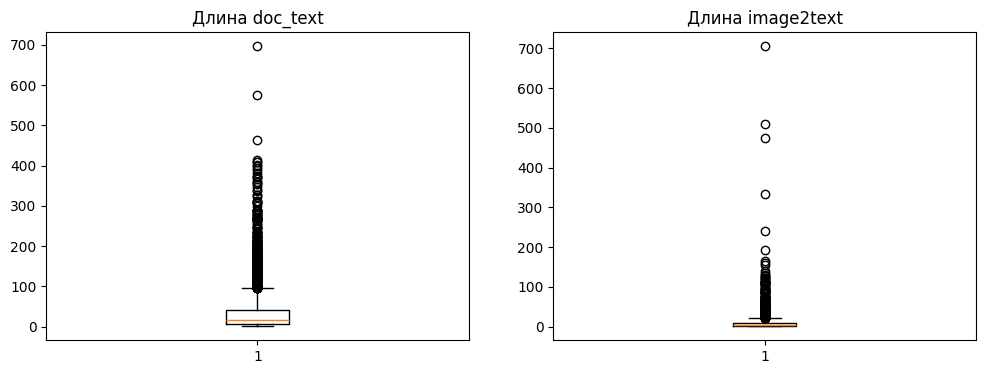

In [184]:
# Длина текстов
df_gen['doc_length'] = df_gen['stemmed_doc_text'].str.split().str.len()
df_gen['image_length'] = df_gen['stemmed_image2text'].str.split().str.len()

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.boxplot(df_gen['doc_length'].dropna())
plt.title('Длина doc_text')

plt.subplot(122)
plt.boxplot(df_gen['image_length'].dropna())
plt.title('Длина image2text')
plt.show()

## 2. Feature Engineering

In [185]:
for col in df_gen[['doc_text', 'image2text', 'speech2text', 'emojis_doc_text', 'cleaned_doc_text', 'cleaned_image2text', 'cleaned_speech2text', 'stemmed_doc_text', 'stemmed_image2text', 'stemmed_speech2text', 'SpaCy_doc_text', 'SpaCy_image2text', 'SpaCy_speech2text']]:
    df_gen[col] = df_gen[col].fillna('').values

In [186]:
tfidf = TfidfVectorizer(
    max_features=5000,       # Ограничиваем количество фич
    min_df=5,                # Игнорировать слова, встречающиеся <5 раз
    max_df=0.7,              # Игнорировать слова, встречающиеся >70% документов
    ngram_range=(1, 2)       # Учитывать словосочетания (1-2 слова)
)

tfidf_low_quality = TfidfVectorizer(
    max_features=1000,
    min_df=10,  # Более строгий фильтр для редких слов
    max_df=0.9,
    token_pattern=r'\b[а-яё]{4,}\b'  # Только слова из 4+ русских букв
)

In [187]:
tfidf_doc = tfidf.fit_transform(df_gen['stemmed_doc_text'].fillna(''))
tfidf_image = tfidf_low_quality.fit_transform(df_gen['stemmed_image2text'].fillna(''))
tfidf_speech = tfidf_low_quality.fit_transform(df_gen['stemmed_speech2text'].fillna(''))

In [188]:
# Кластеризация для каждого типа текста
n_clusters = 6

kmeans_doc = KMeans(n_clusters=n_clusters).fit(tfidf_doc)
kmeans_image = KMeans(n_clusters=n_clusters).fit(tfidf_image)
kmeans_speech = KMeans(n_clusters=n_clusters).fit(tfidf_speech)

In [189]:
# Добавляем результаты в датафрейм
df_gen['cluster_doc'] = kmeans_doc.labels_
df_gen['cluster_image'] = kmeans_image.labels_
df_gen['cluster_speech'] = kmeans_speech.labels_

In [190]:
print("Сходство кластеров doc_text с исходными классами:",
      adjusted_rand_score(df_gen['class'], df_gen['cluster_doc']))

print("Сходство кластеров image2text с исходными классами:",
      adjusted_rand_score(df_gen['class'], df_gen['cluster_image']))

print("Сходство кластеров speech2text с исходными классами:",
      adjusted_rand_score(df_gen['class'], df_gen['cluster_speech']))

Сходство кластеров doc_text с исходными классами: 0.07012376737725416
Сходство кластеров image2text с исходными классами: 0.00045828181066072583
Сходство кластеров speech2text с исходными классами: 3.612029140884134e-05


In [191]:
def custom_tokenizer(text):
    # Удаляем спецсимволы (но сохраняем слова с дефисами и апострофами)
    text = re.sub(r'[^\w\s-]', '', text.lower())
    
    # Токенизация с учетом русской морфологии
    tokens = word_tokenize(text, language='russian')
    
    # Фильтрация стоп-слов и коротких токенов
    russian_stopwords = set(stopwords.words('russian'))
    tokens = [token for token in tokens 
              if token not in russian_stopwords 
              and len(token) > 2 
              and not token.isdigit()]
    
    return tokens

In [192]:
tfidf_advanced = TfidfVectorizer(
    tokenizer=custom_tokenizer,          # Наш токенизатор
    analyzer='word',                     # Анализ по словам
    ngram_range=(1, 2),                  # Учитываем словосочетания
    min_df=3,                            # Игнорировать редкие слова (<3 документов)
    max_df=0.85,                         # Игнорировать слишком частые слова (>85% документов)
    sublinear_tf=True,                   # Логарифмическое масштабирование TF
    smooth_idf=True,                     # Сглаживание IDF
    norm='l2',                           # Нормализация векторов
    lowercase=True                       # Приводить к нижнему регистру (уже делаем в токенизаторе)
)

In [193]:
tfidf_doc_adv = tfidf_advanced.fit_transform(df_gen['SpaCy_doc_text'].fillna(''))

D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [194]:
kmeans_doc_adv = KMeans(n_clusters=n_clusters).fit(tfidf_doc_adv)

In [195]:
df_gen['cluster_doc_adv'] = kmeans_doc_adv.labels_

In [196]:
print("Сходство кластеров doc_text с исходными классами:",
      adjusted_rand_score(df_gen['class'], df_gen['cluster_doc_adv']))

Сходство кластеров doc_text с исходными классами: 0.03372827914105989


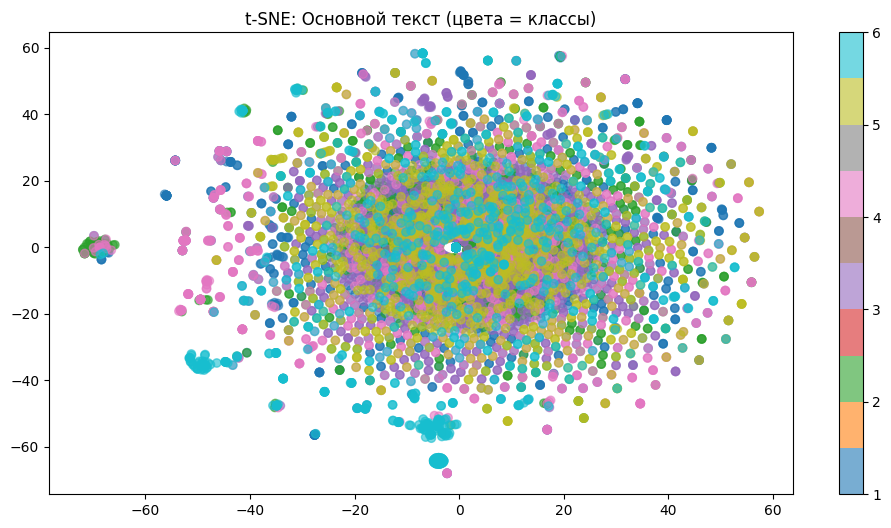

In [197]:
# Для основного текста
tsne = TSNE(n_components=2, random_state=42)
tfidf_doc_2d = tsne.fit_transform(tfidf_doc.toarray())

plt.figure(figsize=(12, 6))
plt.scatter(tfidf_doc_2d[:, 0], tfidf_doc_2d[:, 1], 
            c=df_gen['class'], cmap='tab10', alpha=0.6)
plt.title('t-SNE: Основной текст (цвета = классы)')
plt.colorbar(ticks=range(1,7))
plt.show()

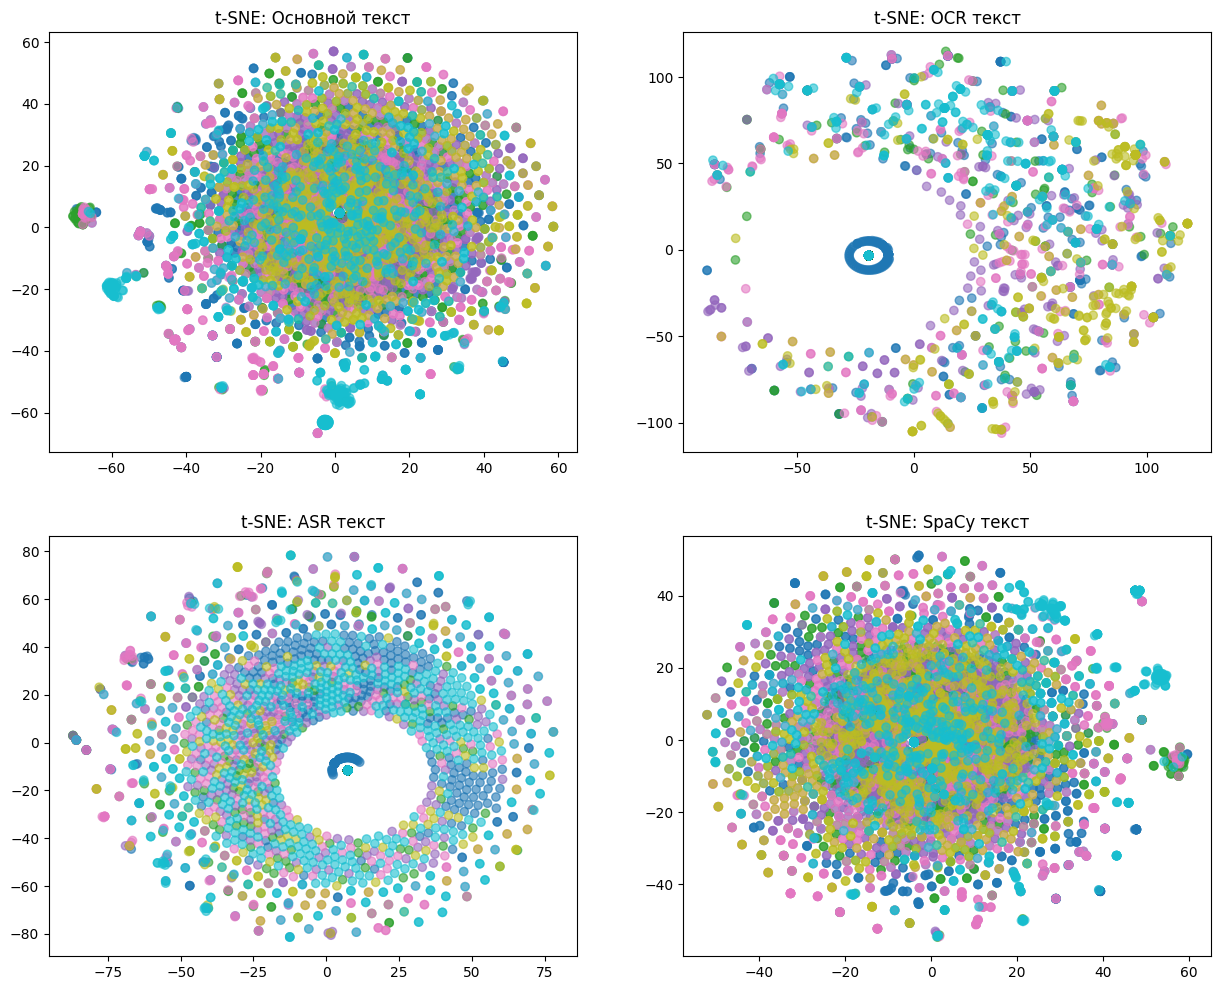

In [198]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sources = {
    'Основной текст': tfidf_doc,
    'OCR текст': tfidf_image, 
    'ASR текст': tfidf_speech,
    'SpaCy текст': tfidf_doc_adv
}

for (name, data), ax in zip(sources.items(), axes.flatten()):
    emb_2d = TSNE(n_components=2).fit_transform(data.toarray())
    ax.scatter(emb_2d[:,0], emb_2d[:,1], c=df_gen['class'], cmap='tab10', alpha=0.6)
    ax.set_title(f't-SNE: {name}')

Визуализация данных в 2D также показывает отсутствие видимых кластеров

In [199]:
results = []
for name, data in sources.items():
    # Кластеризация
    kmeans = KMeans(n_clusters=6, random_state=42).fit(data)
    
    # Оценка
    sil_score = silhouette_score(data, kmeans.labels_)
    rand_score = adjusted_rand_score(df_gen['class'], kmeans.labels_)
    
    results.append({
        'Источник': name,
        'Silhouette': sil_score,
        'Adjusted Rand': rand_score
    })

pd.DataFrame(results).sort_values('Adjusted Rand', ascending=False)

,Источник,Silhouette,Adjusted Rand
3,SpaCy текст,0.020774,0.015412
0,Основной текст,0.007333,0.002308
1,OCR текст,0.643193,0.000056
2,ASR текст,0.553694,0.000032


Результаты теста на силуэт и скорректированная Accuracy показывают низкие результаты

При этом для OCR и ASR результаты на силуэт достаточно высоки (Accuracy ниже 1%), что может говорить о том, что кол-во кластеров ~угадано, но все они перепутаны

Выведем по 10 топ слов для SpaCy_doc_text

In [200]:
# Для tfidf_advanced (SpaCy)
feature_names = tfidf_advanced.get_feature_names_out()
tfidf_matrix = tfidf_doc_adv.tocsr()  # Конвертируем в CSR формат

for class_idx in range(6):
    # Получаем индексы документов класса
    doc_indices = df_gen[df_gen['class'] == class_idx+1].index
    # Вычисляем среднее TF-IDF по классу
    class_tfidf = tfidf_matrix[doc_indices].mean(axis=0).A1
    
    top_words_idx = class_tfidf.argsort()[-10:][::-1]
    print(f"\nКласс {class_idx+1} топ-10 слов:")
    print([feature_names[i] for i in top_words_idx])


Класс 1 топ-10 слов:
['выпуск', 'видео', 'это', 'канал', 'новый', 'смотреть', 'моем', 'канале', 'ссылка', 'ссылки']

Класс 2 топ-10 слов:
['опубликован', 'опубликован комментарий', 'комментарий записи', 'это', 'комментарий', 'записи', 'спасибо', 'очень', 'сегодня', 'день']

Класс 3 топ-10 слов:
['это', 'россии', 'которые', 'крокус', 'очень', 'года', 'люди', 'который', 'время', 'сегодня']

Класс 4 топ-10 слов:
['писать', 'это', 'шоу', 'ленорман', 'июля', 'билеты', 'сегодня', 'выпуск', 'оракул', 'новый']

Класс 5 топ-10 слов:
['это', 'евро', 'матч', 'футбол', 'испания', 'англия', 'динамо', 'сегодня', 'пенальти', 'очень']

Класс 6 топ-10 слов:
['стендап', 'стендап стендап', 'камеди', 'вумен', 'камеди вумен', 'тнт', 'натнт', 'стендап натнт', 'натнт стендап', 'шапке']


## 3.  Подбор признаков, их анализ и оценка важности

Попробуем улучшить результаты кластеризации, изменив характеристики токенизаторов

In [201]:
tfidf = TfidfVectorizer(
    max_features=5000,       # Ограничиваем количество фич
    min_df=10,                # Игнорировать слова, встречающиеся <5 раз
    max_df=0.6,              # Игнорировать слова, встречающиеся >70% документов
    ngram_range=(1, 3)       # Учитывать словосочетания (1-2 слова)
)

tfidf_low_quality = TfidfVectorizer(
    max_features=500,
    min_df=10,  # Более строгий фильтр для редких слов
    max_df=0.8,
    token_pattern=r'\b[а-яё]{4,}\b'  # Только слова из 4+ русских букв
)

tfidf_advanced = TfidfVectorizer(
    tokenizer=custom_tokenizer,          # Наш токенизатор
    analyzer='word',                     # Анализ по словам
    ngram_range=(1, 3),                  # Учитываем словосочетания
    min_df=6,                            # Игнорировать редкие слова (<3 документов)
    max_df=0.85,                         # Игнорировать слишком частые слова (>85% документов)
    sublinear_tf=True,                   # Логарифмическое масштабирование TF
    smooth_idf=True,                     # Сглаживание IDF
    norm='l2',                           # Нормализация векторов
    lowercase=True                       # Приводить к нижнему регистру (уже делаем в токенизаторе)
)

In [202]:
tfidf_doc = tfidf.fit_transform(df_gen['stemmed_doc_text'].fillna(''))
tfidf_image = tfidf_low_quality.fit_transform(df_gen['stemmed_image2text'].fillna(''))
tfidf_speech = tfidf_low_quality.fit_transform(df_gen['stemmed_speech2text'].fillna(''))
tfidf_doc_adv = tfidf_advanced.fit_transform(df_gen['SpaCy_doc_text'].fillna(''))

D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [203]:
print("Форма TF-IDF матрицы:", tfidf_doc.shape)

Форма TF-IDF матрицы: (6000, 3953)


In [204]:
# Токенизация для SpaCy
nlp = spacy.load("ru_core_news_sm")
def spacy_tokenize(text):
    if isinstance(text, float) and np.isnan(text):  # Пропускаем NaN
        return []
    
    doc = nlp(text)
    return [
        token.text for token in doc
        if not token.is_space  # Игнорируем пробелы
    ]

In [205]:
df_gen['SpaCy_doct_text_tokens'] = df_gen['SpaCy_doc_text'].apply(spacy_tokenize)

In [206]:
print("Пример токенов:", df_gen['SpaCy_doct_text_tokens'].iloc[0][:10]) # Первые 10

Пример токенов: ['твой', 'лучший', 'секс', 'спрятан', 'здесь', 'делюсь', 'каналом', 'дипломированного', 'сексолога', '.']


## 4. Обучение нескольких моделей, их сравнение

In [207]:
X_combined = hstack([
    tfidf_doc * 0.3,
    tfidf_doc_adv * 0.6, # Делаем вес текста для SpaCy выше
    tfidf_image * 0.1,  # Понижаем вес OCR текста
    tfidf_speech * 0.05  # И ASR тоже
])

In [208]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, 
    df_gen['class'], 
    test_size=0.2,
    stratify=df_gen['class']
)

In [209]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:\n", classification_report(y_test, y_pred))


Logistic Regression:
               precision    recall  f1-score   support

           1       0.69      0.61      0.65       200
           2       0.45      0.52      0.48       200
           3       0.75      0.82      0.79       200
           4       0.59      0.40      0.47       200
           5       0.67      0.80      0.72       200
           6       0.58      0.59      0.59       200

    accuracy                           0.62      1200
   macro avg       0.62      0.62      0.62      1200
weighted avg       0.62      0.62      0.62      1200


Random Forest:
               precision    recall  f1-score   support

           1       0.69      0.65      0.67       200
           2       0.41      0.56      0.48       200
           3       0.79      0.81      0.80       200
           4       0.52      0.32      0.39       200
           5       0.66      0.69      0.67       200
           6       0.60      0.61      0.61       200

    accuracy                         

Статистики для классов 2 и 4 хуже всего

Модели LogReg и SVM лучше, но не достаточно хорошо, всего 65% accuracy

Построим матрицу, чтобы визуализировать, какие классы больше всего путает модель SVM

<Figure size 1000x800 with 0 Axes>

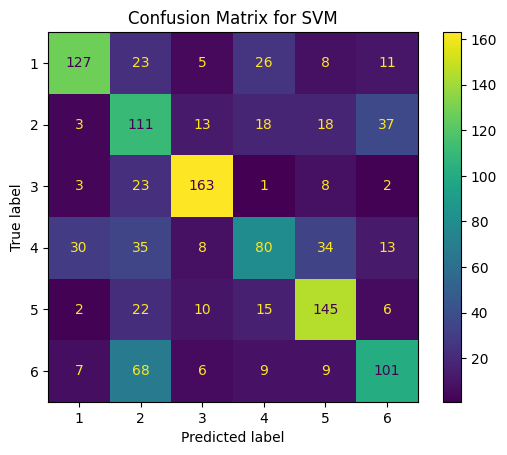

In [210]:
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(models["SVM"], X_test, y_test)
plt.title("Confusion Matrix for SVM")
plt.show()

Пробуем построить те же модели, предварительно создав метапризнаки

Создаем метапризнаки (и сразу их скейлируем для конкретной работы моделей)

In [211]:
meta_features = pd.DataFrame({
    'doc_length': df_gen['doc_text'].str.len(),          # Длина исходного текста
    'num_words': df_gen['stemmed_doc_text'].str.split().str.len(),  # Количество слов
    'num_emojis': df_gen['emojis_doc_text'].str.count(' ') + 1,    # Число эмодзи
    'has_image': df_gen['image2text'].notna().astype(int),          # Наличие картинки
    'has_speech': df_gen['speech2text'].notna().astype(int)         # Наличие аудио
})

Проверяем отсутствие пропусков

In [212]:
print(meta_features.isna().sum())

doc_length    0
num_words     0
num_emojis    0
has_image     0
has_speech    0
dtype: int64


In [213]:
scaler = StandardScaler()
meta_scaled = scaler.fit_transform(meta_features)

In [214]:
# Объединяем с текстовыми признаками
X_combined_meta = hstack([X_combined, meta_scaled])

In [215]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined_meta, 
    df_gen['class'], 
    test_size=0.2,
    stratify=df_gen['class']
)

In [216]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:\n", classification_report(y_test, y_pred))


Logistic Regression:
               precision    recall  f1-score   support

           1       0.69      0.66      0.67       200
           2       0.49      0.47      0.48       200
           3       0.79      0.76      0.77       200
           4       0.57      0.34      0.43       200
           5       0.71      0.65      0.68       200
           6       0.52      0.83      0.64       200

    accuracy                           0.62      1200
   macro avg       0.63      0.62      0.61      1200
weighted avg       0.63      0.62      0.61      1200


Random Forest:
               precision    recall  f1-score   support

           1       0.66      0.62      0.64       200
           2       0.45      0.62      0.53       200
           3       0.72      0.79      0.75       200
           4       0.56      0.38      0.45       200
           5       0.65      0.62      0.63       200
           6       0.71      0.68      0.69       200

    accuracy                         

После добавления мета признаков качество моделей либо почти не изменилось (для Log Reg accuracy стала 0.62), либо сильно ухудшилось (для SVM стало 0.55)

Вернемся на этап с токенизацией и попробуем BERT

In [217]:
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [218]:
combined_text = []

for i in range(len(df_gen)):
    # Объединяем значения из трех столбцов через пробел
    combined = str(df_gen['doc_text'].iloc[i]) + ' ' + \
                   str(df_gen['image2text'].iloc[i]) + ' ' + \
                   str(df_gen['speech2text'].iloc[i])
    combined_text.append(combined)

In [219]:
df_gen['combined_text'] = combined_text

In [220]:
texts = df_gen['combined_text']
labels = df_gen['class'].values - 1  # BERT ожидает классы 0-5 вместо 1-6

In [221]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels
)

In [222]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=64)

In [223]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [224]:
train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

In [225]:
# Загрузка модели
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    ignore_mismatched_sizes=True
)
print("Последний слой инициализирован заново - это нормально для transfer learning")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Последний слой инициализирован заново - это нормально для transfer learning


In [231]:
project_root = Path.cwd().parent
model_dir = project_root / "models" / "bert_classifier"
run_dir = model_dir / "training_runs" / f"run_{datetime.now().strftime('%Y-%m-%d_%H-%M')}"
run_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    
    # Дополнительная метрика: учитываем второй вариант
    probs = torch.nn.functional.softmax(torch.tensor(p.predictions), dim=-1)
    top2_correct = 0
    for prob, label in zip(probs, p.label_ids):
        _, top2_idx = torch.topk(prob, k=2)
        if label in top2_idx:
            top2_correct += 1
    
    return {
        'accuracy': accuracy,
        'top2_accuracy': top2_correct / len(p.label_ids)
    }

In [233]:
# Параметры обучения
training_args = TrainingArguments(
    output_dir=str(run_dir / "checkpoints"),  # Путь для чекпоинтов
    logging_dir=str(run_dir / "logs"),        # Путь для логов
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",  
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Метрика для оценки
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': accuracy_score(p.label_ids, preds)}

# Создание Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Запуск обучения
trainer.train()

D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.005300,0.966620,0.654167
2,0.705900,0.946978,0.666667
3,0.585600,0.979309,0.685833


D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1800, training_loss=0.8326802041795519, metrics={'train_runtime': 2721.783, 'train_samples_per_second': 5.291, 'train_steps_per_second': 0.661, 'total_flos': 473616908697600.0, 'train_loss': 0.8326802041795519, 'epoch': 3.0})

Плюсы:
- Accuracy растёт с 65.42% до 68.58%
- Training Loss стабильно уменьшается (1.01 -> 0.59)

Минусы:
- Validation Loss увеличился на 3-й эпохе (0.947 -> 0.979) - признаки переобучения
- Accuracy на валидации выросла всего на 2% на последней эпохе

In [234]:
def predict_with_two_results(model, tokenizer, texts, threshold=0.75):
    """Возвращает список, где каждый элемент:
    - [top_class] если уверенность >= threshold
    - [top_class, second_class] если уверенность < threshold
    """
    # Токенизация
    inputs = tokenizer(list(texts), truncation=True, padding=True, max_length=64, return_tensors="pt")
    
    # Предсказание
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Обработка результатов
    results = []
    for prob in probs:
        top2_probs, top2_indices = torch.topk(prob, k=2)
        if top2_probs[0] >= threshold:
            results.append([top2_indices[0].item() + 1])  # +1 чтобы вернуть классы 1-6
        else:
            results.append([top2_indices[0].item() + 1, top2_indices[1].item() + 1])
    
    return results

In [ ]:
# Пример предсказания на тестовых данных
test_texts_list = test_texts.tolist()
predictions = predict_with_two_results(model, tokenizer, test_texts_list)

In [235]:
# Вывод результатов для первых 5 примеров
for i in range(5):
    print(f"Текст: {test_texts_list[i][:50]}...")
    if len(predictions[i]) == 1:
        print(f"Предсказание: {predictions[i][0]} (уверенность >= 75%)")
    else:
        print(f"Предсказания: {predictions[i][0]} и {predictions[i][1]} (низкая уверенность)")
    print("-" * 50)

Текст: Дмитрий Губерниев: «Станковича скоро выгонят. Поря...
Предсказание: 5 (уверенность >= 75%)
--------------------------------------------------
Текст: Во Франции инсайдят, что Мбаппе не сыграет до конц...
Предсказание: 5 (уверенность >= 75%)
--------------------------------------------------
Текст: Давайте займемся настоящим делом и начнем верить в...
Предсказание: 5 (уверенность >= 75%)
--------------------------------------------------
Текст: https://t.me/s/seregina_on_air/5201  Конкурс прогн...
Предсказание: 5 (уверенность >= 75%)
--------------------------------------------------
Текст:  Мы снова играем в Кубке России!  Будет большой пр...
Предсказания: 5 и 1 (низкая уверенность)
--------------------------------------------------


Изменим гиперпараметры

In [236]:
run_dir = model_dir / "training_runs" / f"run_{datetime.now().strftime('%Y-%m-%d_%H-%M')}"
run_dir.mkdir(parents=True, exist_ok=True)

In [237]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    hidden_dropout_prob=0.2,    # Увеличиваем dropout
    attention_probs_dropout_prob=0.2,
    ignore_mismatched_sizes=True
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [238]:
training_args = TrainingArguments(
    output_dir=str(run_dir / "checkpoints"),  # Путь для чекпоинтов
    logging_dir=str(run_dir / "logs"),        # Путь для логов
    num_train_epochs=4,                    # Увеличим на 1 эпоху
    per_device_train_batch_size=16,        # Увеличим батч если позволяет память
    learning_rate=3e-5,                    # Увеличим с 2e-5 до 3e-5
    warmup_steps=100,                      # Уменьшим прогрев
    weight_decay=0.05,                     # Добавим регуляризацию
    logging_steps=30,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True                              # Включим (есть GPU)
)

Добавим в трейнер возможность новой остановки, в случае, если на новой эпохе показатели ухудшатся

In [239]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [240]:
trainer.train()

D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.109400,1.030831,0.613333
2,0.847900,0.975919,0.661667
3,0.696800,0.978713,0.658333
4,0.497300,0.994146,0.672500


D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1200, training_loss=0.8574635648727417, metrics={'train_runtime': 2733.1418, 'train_samples_per_second': 7.025, 'train_steps_per_second': 0.439, 'total_flos': 631489211596800.0, 'train_loss': 0.8574635648727417, 'epoch': 4.0})

In [241]:
# Пример предсказания на тестовых данных
test_texts_list = test_texts.tolist()
predictions = predict_with_two_results(model, tokenizer, test_texts_list)

In [243]:
# Вывод результатов для первых 5 примеров
for i in range(4, 9):
    print(f"Текст: {test_texts_list[i][:50]}...")
    if len(predictions[i]) == 1:
        print(f"Предсказание: {predictions[i][0]} (уверенность >= 75%)")
    else:
        print(f"Предсказания: {predictions[i][0]} и {predictions[i][1]} (низкая уверенность)")
    print("-" * 50)

Текст:  Мы снова играем в Кубке России!  Будет большой пр...
Предсказания: 5 и 4 (низкая уверенность)
--------------------------------------------------
Текст: Что уже сделал Рэтклифф в МЮ, четыре новичка на пр...
Предсказания: 3 и 5 (низкая уверенность)
--------------------------------------------------
Текст: Печальные новости тоже есть…. Утром я проснулась б...
Предсказание: 2 (уверенность >= 75%)
--------------------------------------------------
Текст: ООООЙ! ЯРСАБАЛЬ! 2-1,   ...
Предсказание: 5 (уверенность >= 75%)
--------------------------------------------------
Текст: У людей разные лингвистические способности, разная...
Предсказания: 5 и 2 (низкая уверенность)
--------------------------------------------------


Изменим значение остановки, чтобы она происходила уже после первого ухудшения

In [244]:
run_dir = model_dir / "training_runs" / f"run_{datetime.now().strftime('%Y-%m-%d_%H-%M')}"
run_dir.mkdir(parents=True, exist_ok=True)

In [245]:
training_args = TrainingArguments(
    output_dir=str(run_dir / "checkpoints"),  # Путь для чекпоинтов
    logging_dir=str(run_dir / "logs"),        # Путь для логов
    report_to="tensorboard",               # Автоматический логи
    logging_strategy="steps",              # Логировать по шагам
    logging_steps=50,                      # Частота логирования
    num_train_epochs=10,                   # Увеличим до 10 эпох
    per_device_train_batch_size=16,        # Увеличим батч если позволяет память
    learning_rate=5e-6,                    # Уменьшаем learning rate
    warmup_steps=100,                      # Уменьшим прогрев
    weight_decay=0.05,                     # Добавим регуляризацию
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,                # Accuracy чем выше тем лучше
    fp16=True                              # Включим (есть GPU)
)

In [246]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=1,
            early_stopping_threshold=0.01,  # Минимальное улучшение
        )
    ]
)

In [247]:
trainer.train()

D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.307000,1.088526,0.663333
2,0.255600,1.207900,0.666667


D:\Studies\MEPhI_ML\Dataton_2\Dataton2\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=600, training_loss=0.3204841057459513, metrics={'train_runtime': 1355.831, 'train_samples_per_second': 35.403, 'train_steps_per_second': 2.213, 'total_flos': 315744605798400.0, 'train_loss': 0.3204841057459513, 'epoch': 2.0})

Результаты показывают, что модель начала переобучаться уже на второй эпохе (Validation Loss увеличился с 1.089 до 1.208 при (небольшой) стагнации Accuracy), расчет остановлен

In [248]:
predictions = predict_with_two_results(model, tokenizer, test_texts_list)

In [249]:
# Вывод результатов для первых 5 примеров
for i in range(4, 9):
    print(f"Текст: {test_texts_list[i][:50]}...")
    if len(predictions[i]) == 1:
        print(f"Предсказание: {predictions[i][0]} (уверенность >= 75%)")
    else:
        print(f"Предсказания: {predictions[i][0]} и {predictions[i][1]} (низкая уверенность)")
    print("-" * 50)

Текст:  Мы снова играем в Кубке России!  Будет большой пр...
Предсказание: 5 (уверенность >= 75%)
--------------------------------------------------
Текст: Что уже сделал Рэтклифф в МЮ, четыре новичка на пр...
Предсказания: 5 и 3 (низкая уверенность)
--------------------------------------------------
Текст: Печальные новости тоже есть…. Утром я проснулась б...
Предсказание: 2 (уверенность >= 75%)
--------------------------------------------------
Текст: ООООЙ! ЯРСАБАЛЬ! 2-1,   ...
Предсказание: 5 (уверенность >= 75%)
--------------------------------------------------
Текст: У людей разные лингвистические способности, разная...
Предсказание: 2 (уверенность >= 75%)
--------------------------------------------------


Попробовать кластеризацию, насколько реально выполнена разметка/разделение датасетов

3 версии датасета:
- только посты
- посты + дополнения
- все источники с маркерами [post] text, [OCR] text, [ASR] text

In [ ]:
# взвешенная конкатенация (тект + OCR + ASR)
def combine_sources(row):
    main_text = row['user_text']
    supplements = ' '.join([row['ocr_text'], row['asr_text']])
    return f"{main_text} [SUPP] {supplements}"  # Маркер для дополнений

## 6. Выбор лучшей модели и объяснение выбора

## 7. Предсказание на тестовых данных